In [3]:
import sys,os
sys.path.append(os.path.abspath(".."))

In [7]:
import torch 
from QuantumWalkModule.OneDimensionQW import QW_base_pure
from QuantumWalkModule.Operator import Op
from QuantumWalkModule.StatesPreparation import *

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [23]:
sns.set_style("darkgrid")

In [46]:
class Experiment1(QW_base_pure):
    def __init__(self, dim : int, coin_conf : dict) -> None:
        self.dim = dim
        self.S = self.Step()
        self.C1, self.C2 = self.Coin(**coin_conf)
        self.S1, self.S2 = self.Step()
        self.U = self.S1 @ self.C1 @ self.S2 @ self.C2
        self.st_gen = States(self.dim)

    def Step(self) -> torch.tensor :
        right = torch.kron(torch.roll(torch.eye(self.dim),1,0), Op.s_l)
        right += torch.kron(torch.eye(self.dim),Op.s_r) 
        left = torch.kron(torch.roll(torch.eye(self.dim),-1,0), Op.s_r)
        left += torch.kron(torch.eye(self.dim),Op.s_l) 
        return right.to(torch.complex64),left.to(torch.complex64)
    
    def make_step(self, state):
        return self.U @ state
    
    def Coin(self, **kwargs) -> tuple:
        th_plus = kwargs.get("th1", np.pi/4)
        th_minus = kwargs.get("th2", np.pi/4)
        C_standard = lambda th : torch.tensor([[np.cos(th/2), -np.sin(th/2)], [np.sin(th/2), np.cos(th/2)]])
        bulk = torch.diag(torch.tensor([1 if i != 0 and  i != self.dim-1 else 0 for i in range(self.dim)]))
        boundary = torch.diag(torch.tensor([0 if i != 0 and  i != self.dim-1 else 1 for i in range(self.dim)]))
        C_plus = torch.kron(bulk,C_standard(th_plus)) + torch.kron(boundary, Op.sx)
        C_minus = torch.kron(bulk,C_standard(th_minus)) + torch.kron(boundary, Op.sx)
        return C_plus.to(torch.complex64), C_minus.to(torch.complex64)

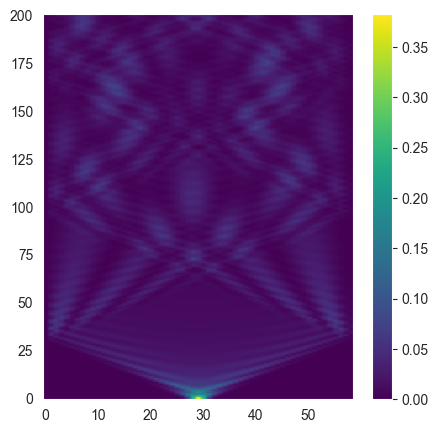

In [47]:
walk = Experiment1(59, {"th1": np.pi/4, "th2": np.pi/11})

data = walk.run(200)

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
cax = ax.imshow(data,origin='lower', cmap='viridis', aspect='auto')
plt.grid(False)
fig.colorbar(cax)
plt.show()

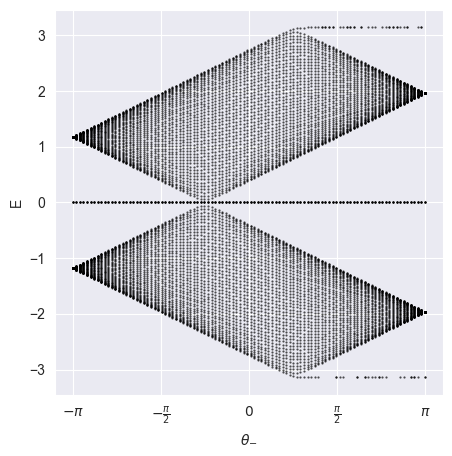

In [60]:
energies = []

x_tick = [-3.14, -1.57, 0, 1.57, 3.14]
x_labs = [r'$-\pi $',r'$-\frac{\pi}{2}$', r'$0$',r'$\frac{\pi}{2}$',r'$\pi$']

th1 = np.pi/4
th2 = np.linspace(-np.pi, np.pi, 100)

for th2_ in th2:
    walk = Experiment1(50, {"th1": th1, "th2": th2_})
    U_ = walk.U
    data = np.sort(np.angle(torch.linalg.eigvals(U_).flatten().numpy()))
    energies.append(data) 

energies = np.array(energies)
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
for i in range(energies.shape[1]):
    ax.scatter(th2, energies[:,i], color='black', alpha=0.7, s = 0.3)
ax.set_xlabel(r"$\theta_{-}$")
ax.set_ylabel(r"E")
plt.xticks(x_tick, x_labs)
plt.show()


In [122]:
def get_eigen_info(th1,th2):
    walk2 = Experiment1(50, {"th1": th1, "th2": th2})
    U_ = walk2.U
    E,V = torch.linalg.eig(U_)
    E = (np.abs(np.angle(E.flatten().numpy())))
    indices = np.argsort(E)
    V = V[:,indices]
    E = E[indices]

    eps = 0.01

    E_zero = (E <0.01) * (E > -0.01)
    E_range = (E <3.14 + 0.01) * (E > 3.14 - 0.01)

    inds = E_zero + E_range

    V_eigs = V[:,inds]
    return E,E[inds], V_eigs

In [123]:
E,E0,V_eigs = get_eigen_info(np.pi/4, np.pi/11)

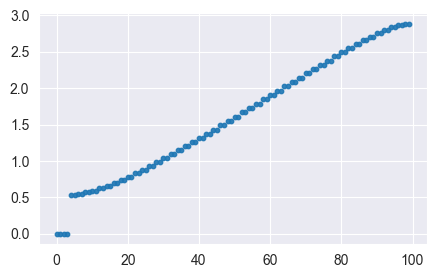

In [124]:

fig = plt.figure(figsize=(5,3))
ax = fig.add_subplot(111)
ax.scatter(range(len(E)),E, alpha=0.9, s = 10)
plt.show()

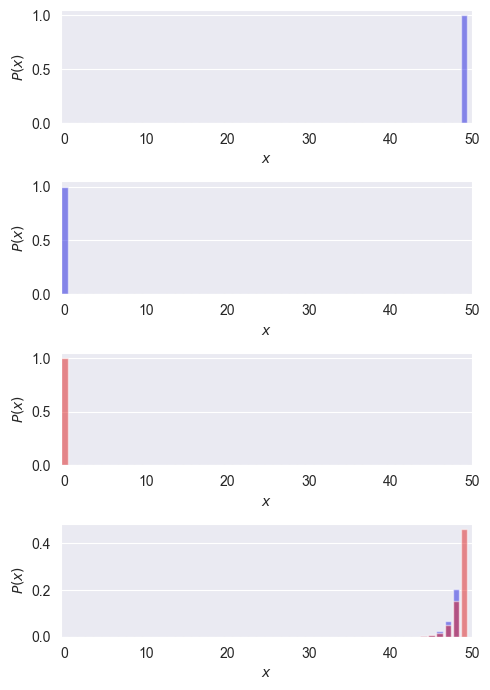

In [126]:
x_tick = [i * 10 for i in range(6)]
x_labs = list(map(str, x_tick))


fig = plt.figure(figsize=(5,7))
for index in range(len(E0)):
    ax = fig.add_subplot(len(E0),1,index +1)
    prob = np.abs(V_eigs[:,index])**2
    prob_plus = prob[0::2]
    prob_minus = prob[1::2]
    sns.barplot(prob_plus, color='blue', alpha=0.5)
    sns.barplot(prob_minus, color='red', alpha=0.5)
    plt.xlabel(r"$x$")
    plt.ylabel(r"$P(x)$")
    plt.xticks(x_tick, x_labs)
plt.tight_layout()
plt.show()